In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import seaborn as sns

from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes import jtplot

In [2]:
filename_stars = "hygdata_v3.csv"

stars_df = pd.read_csv(filename_stars)
stars_df = stars_df[["id", "proper", "lum", "spect", "ci", "comp", "comp_primary", "x", "y", "z", "absmag"]]

In [3]:
stars_df["star_spectral_type_letter"] = stars_df["spect"].str.extract("([OBAFGKM])[0-9].*")
stars_df["star_spectral_type_number"] = stars_df["spect"].str.extract("[OBAFGKM]([0-9]).*")
# stars_df["star_HR_type"] =  stars_df["spect"].str.extract("[OBAFGKM][0-9][\s\-\d\.]?([IV]+)")
stars_df["star_HR_type"] =  stars_df["spect"].str.extract("[OBAFGKM][0-9][^\w]?([IV]+)")

stars_df["mass_approx"] = stars_df["lum"].pow(3.5)

# stars_df["temp_calculated_2"] =  (5000 / (stars_df["ci"] + 1.84783)) + (5000 / (stars_df["ci"] + .673913))
stars_df["temp_calculated"] = 4600*(1/(0.92*stars_df["ci"]+1.7) + 1/(0.92*stars_df["ci"]+0.62))
stars_df["radius"] = stars_df["lum"] * 7.35355e-8 * (5.778 / 3.828e+26) * stars_df["temp_calculated"] # in solar radii

###################
# Move this after classification
# stars_df["spectral_combo"] = stars_df["star_spectral_type_letter"] + stars_df["star_spectral_type_number"] #+ " " + stars_df["star_HR_type"]
####################

#stars_df = stars_df[stars_df["spectral_combo"].notnull()]

#print(list(stars_df["spectral_combo"].unique()))

# print(list(stars_df["star_spectral_type_letter"].unique()))
# print("-----------------")
# print(stars_df.groupby("star_spectral_type_letter").agg(func="count").head(9))

# print(list(stars_df["spect"].unique()))
print(list(stars_df["star_HR_type"].unique()))
# stars_df["star_HR_type"] = np.where(stars_df["star_HR_type"].isna(), "NAN", stars_df["star_HR_type"])
# stars_grouped = stars_df[["spect", "star_HR_type"]].groupby("star_HR_type").agg(func="count").head(9)
# print(stars_grouped)

# Build classifiers
# x = "ci" (colour index)
# y = "abs" (absolute magnitude)
# Ignore already classified stars

# XXXXX = gradient (to be calculated)
# BBBBB = intercept (to be calculated)


# Temporary solution, increase accuracy using clustering/learning methods?
# stars_df["star_HR_type"] = np.where(
#     (stars_df["star_HR_type"].isna()) & 
#     (stars_df["absmag"] > XXXXX * stars_df["ci"] + BBBBB), 
#     "I", stars_df["star_HR_type"]) # supergiants


# stars_df["star_HR_type"] = np.where(
#     (stars_df["star_HR_type"].isna()) & 
#     (stars_df["absmag"] > XXXXX * stars_df["ci"] + BBBBB) & 
#     (stars_df["absmag"] < XXXXX * stars_df["ci"] + BBBBB), 
#     "III", stars_df["star_HR_type"]) # giants


# stars_df["star_HR_type"] = np.where(
#     (stars_df["star_HR_type"].isna()) & 
#     (stars_df["absmag"] > XXXXX * stars_df["ci"] + BBBBB) & 
#     (stars_df["absmag"] < XXXXX * stars_df["ci"] + BBBBB), 
#     "V", stars_df["star_HR_type"]) # main sequence

# stars_df["star_HR_type"] = np.where(
#     (stars_df["star_HR_type"].isna()) & 
#     (stars_df["absmag"] < XXXXX * stars_df["ci"] + BBBBB),
#     "VII", stars_df["star_HR_type"]) # white dwarf

['V', nan, 'III', 'IV', 'II', 'I', 'VII']


In [4]:
stars_plotted = stars_df[stars_df["star_HR_type"].notna()]
stars_plotted.shape

(54956, 17)

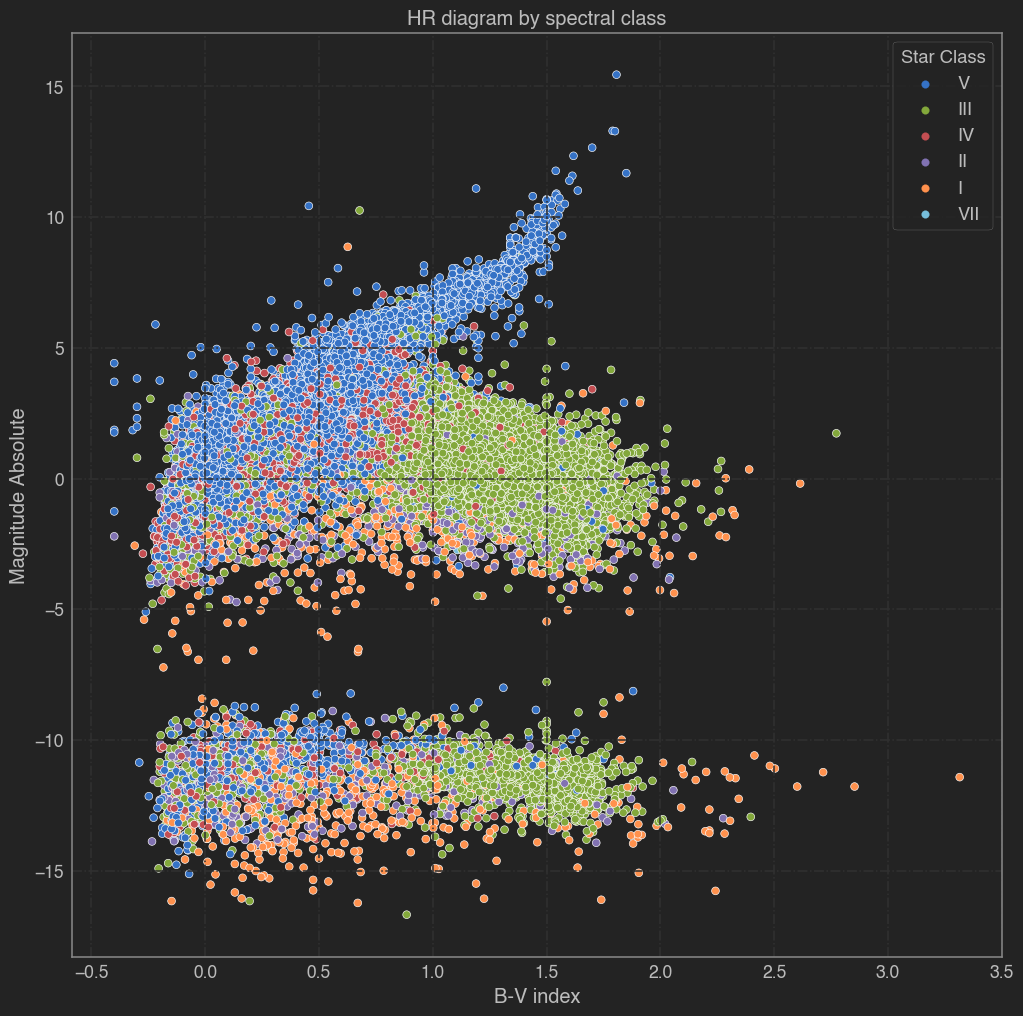

In [18]:
jtplot.style(theme='monokai', gridlines= '-.',figsize=(15,15))

sns.scatterplot(data = stars_plotted, x = 'ci', y = 'absmag', hue="star_HR_type")
plt.title('HR diagram by spectral class')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium')

plt.xlabel('B-V index')
plt.ylabel('Magnitude Absolute')

plt.tight_layout
plt.show()

In [5]:
spectral_info_filename = "Spectral Information"
spectral_info_df = pd.read_csv(spectral_info_filename, delim_whitespace=True)
spectral_info_df = spectral_info_df.set_index("Class")


# Now redundant, delete after git push
classes  = ["O", "B", "A", "F", "G", "K", "M"]

df = pd.DataFrame(columns=["temperature_lookup"])

for letter in classes:
    temp_max_class = spectral_info_df.loc[letter]["Temperature_max"]
    temp_min_class = spectral_info_df.loc[letter]["Temperature_min"]
    diff = temp_max_class - temp_min_class
    temp_max_subclass = temp_max_class

    for i in range(10):
        index_temp = letter + str(i)

        df2 = pd.DataFrame({
            "temperature_lookup": [temp_max_subclass],
        },
        index = [index_temp])

        df = pd.concat([df, df2])

        # print(index_temp)
        # print(round(temp_max_subclass, -1))
        # print("---------")

        temp_max_subclass = temp_max_subclass - diff/9

stars_df["temperature_lookup"] = 0

for index, row in df.iterrows():
    #print(index)
    stars_df["temperature_lookup"] = np.where(stars_df["spectral_combo"] == index, int(row["temperature_lookup"]), stars_df["temperature_lookup"])

print(stars_df[stars_df["temperature_lookup"] > 1].size)
stars_df[stars_df["temperature_lookup"]> 1].head(10)


#stars_df.style.set_sticky(1).set_sticky(0)

KeyError: 'spectral_combo'

In [16]:
def bv2rgb(bv):
    # bv is the B-V colour index of a star

    t = (5000 / (bv + 1.84783)) + (5000 / (bv + .673913))
    # t is the temperature of the star

    x, y = 0, 0
    
    if 1667 <= t <= 4000:
        x = .17991 - (2.66124e8 / t**3) - (234358 / t**2) + (877.696 / t)
    elif 4000 < t:
        x = .24039 - (3.02585e9 / t**3) + (2.10704e6 / t**2) + (222.635 / t)
        
    if 1667 <= t <= 2222:
        y = (-1.1063814 * x**3) - (1.34811020 * x**2) + 2.18555832 * x - .20219683
    elif 2222 < t <= 4000:
        y = (-.9549476 * x**3) - (1.37418593 * x**2) + 2.09137015 * x - .16748867
    elif 4000 < t:
        y = (3.0817580 * x**3) - (5.87338670 * x**2) + 3.75112997 * x - .37001483
        
    X = 0 if y == 0 else x / y
    Z = 0 if y == 0 else (1 - x - y) / y
    
    r, g, b = np.dot([X, 1., Z],
        [[3.2406, -.9689, .0557], [-1.5372, 1.8758, -.204], [-.4986, .0415, 1.057]])
    
    R = np.clip(12.92 * r if (r <= 0.0031308) else 1.4 * (r**2 - .285714), 0, 1)
    G = np.clip(12.92 * g if (g <= 0.0031308) else 1.4 * (g**2 - .285714), 0, 1)
    B = np.clip(12.92 * b if (b <= 0.0031308) else 1.4 * (b**2 - .285714), 0, 1)
    
    return [R, G, B]

stars_df["colors"] = stars_df['ci'].apply(bv2rgb)
# Use this temperature to determine the stars spectral class!

stars_df["R"] = stars_df["colors"].str[0]
stars_df["G"] = stars_df["colors"].str[1]
stars_df["B"] = stars_df["colors"].str[2]

In [ ]:
#stars_df.style.set_sticky(1).set_sticky(0)

print(stars_df["x"].max())
print(stars_df["x"].min())

print(stars_df["y"].max())
print(stars_df["y"].min())

print(stars_df["z"].max())
print(stars_df["z"].min())



99982.37269
-99950.39127
99996.06551
-99979.24619
99862.51367
-99964.98227


In [ ]:
# Finding type of star (HR classification)